# Differential abundance analysis with Milo in python

**Author:** Emma Dann <br>
**Date:** 16/10/2020

In this vignette we will demonstrate how to use the R package [`miloR`](https://github.com/MikeDMorgan/miloR) for differential abundance analysis on [`anndata`](https://github.com/theislab/anndata) objects, to allow interoperability with workflows using [`scanpy`](https://scanpy.readthedocs.io/en/stable/) for analysis of single cell datasets.

If you are somewhat comfortable using R, we recommend saving your anndata object as H5AD, loading it in R as `SingleCellExperiment` using the [`zellconverter` package](https://theislab.github.io/zellkonverter/), and then follow the `miloR` vignettes from there. This way you won't have to use a python environment that includes an R installation, which can be a bit of a nightmare. You can also check out the [Scanpy in R vignette](https://theislab.github.io/scanpy-in-R/#content) to see how you can use your favourite scanpy functionality in an R session. 

However, if you really want to stay away from R as much as possible and you'd like to incorporate differential abundance analysis in your python workflow, this vignette is for you.

We will use the [`anndata2ri`](https://github.com/theislab/anndata2ri) package to allow conversion between `anndata` and `SingleCellExperiment` objects, and viceversa. The code from the Theis lab [single cell tutorial](https://github.com/theislab/single-cell-tutorial/blob/master/latest_notebook/Case-study_Mouse-intestinal-epithelium_1906.ipynb) was really useful to make python-R interoperability work.

## Preparations

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import anndata
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize']=(8,8) #rescale figures
sc.settings.verbosity = 3

### r2py set-up
First of all we need to install `anndata2ri`. In a terminal run:
```
pip install anndata2ri
# or
conda install -c bioconda anndata2ri
```

Please refer to the [README](https://github.com/theislab/anndata2ri/blob/master/README.rst) for troubleshooting

In [2]:
import anndata2ri
import rpy2.rinterface_lib.callbacks
import logging

In [3]:
# Ignore R warning messages
#Note: this can be commented out to get more verbose R output
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

Activate the anndata2ri conversion between SingleCellExperiment and AnnData

In [4]:
anndata2ri.activate()

Loading the `rpy2` extension enables cell magic to be used. This runs R code in jupyter notebook cells.

In [5]:
%load_ext rpy2.ipython

### Milo set-up

We need to install the R package from github. 

In [84]:
%%R
devtools::install_github("MikeDMorgan/miloR")

These packages have more recent versions available.
It is recommended to update all of them.
Which would you like to update?

 1: All                                             
 2: CRAN packages only                              
 3: None                                            
 4: vctrs        (0.3.2       -> 0.3.4      ) [CRAN]
 5: rlang        (0.4.7       -> 0.4.8      ) [CRAN]
 6: glue         (1.4.1       -> 1.4.2      ) [CRAN]
 7: RcppArmad... (0.9.900.2.0 -> 0.9.900.3.0) [CRAN]
 8: igraph       (1.2.5       -> 1.2.6      ) [CRAN]
 9: cpp11        (0.2.1       -> 0.2.3      ) [CRAN]
10: cli          (2.0.2       -> 2.1.0      ) [CRAN]
11: tidyr        (1.1.1       -> 1.1.2      ) [CRAN]
12: tibble       (3.0.3       -> 3.0.4      ) [CRAN]
13: ps           (1.3.4       -> 1.4.0      ) [CRAN]
14: processx     (3.4.3       -> 3.4.4      ) [CRAN]
15: backports    (1.1.9       -> 1.1.10     ) [CRAN]
16: callr        (3.4.3       -> 3.5.1      ) [CRAN]
17: withr        (2.2.0   

Enter one or more numbers, or an empty line to skip updates: 


✔  checking for file ‘/tmp/RtmpiKZ7OC/remotes38586c49afa9/MikeDMorgan-miloR-b27a70f/DESCRIPTION’ (605ms)
─  preparing ‘miloR’:
✔  checking DESCRIPTION meta-information ...
─  checking for LF line-endings in source and make files and shell scripts
─  checking for empty or unneeded directories
─  looking to see if a ‘data/datalist’ file should be added
     NB: this package now depends on R (>= 3.5.0)
─  building 'miloR_0.1.0.tar.gz'
   


In [6]:
%%R
library(miloR)
library(igraph)

## Load and prepare example dataset

For this vignette I will use the mouse gastrulation data from [Pijuan-Sala et al. 2019](https://www.nature.com/articles/s41586-019-0933-9). The dataset can be downloaded as a `SingleCellExperiment` object from the [`MouseGastrulationData`](https://bioconductor.org/packages/3.12/data/experiment/html/MouseGastrulationData.html) package on Bioconductor. I will download just a subset of samples to make the vignette faster, 6 samples at stage E7 and 6 samples at stage E7.5.

We will load this data and convert it to an `anndata` for the sake of our vignette. The only thing you need to do is to add `-o <object-name>` to the end of the R magic line in your jupyter notebook.

In [7]:
%%R -o embryo_data 
# BiocManager::install("MouseGastrulationData")
library(MouseGastrulationData)        

embryo_data = EmbryoAtlasData(samples = c(2,  3,  4,  6, 10, 14, 15, 19, 20, 30, 31, 32))

Now we should have the mouse embryo data in an `anndata` object.

In [8]:
embryo_data

AnnData object with n_obs × n_vars = 29447 × 29452
    obs: 'cell', 'barcode', 'sample', 'pool', 'stage', 'sequencing.batch', 'theiler', 'doub.density', 'doublet', 'cluster', 'cluster.sub', 'cluster.stage', 'cluster.theiler', 'stripped', 'celltype', 'colour'
    var: 'ENSEMBL', 'SYMBOL'
    obsm: 'pca.corrected', 'X_umap'

This dataset was batch corrected using MNN and now contains reduced dimensions saved in the `obsm` slot as `'pca.corrected'`. Let's rename that to `X_pca`, for this is the slot that scanpy functions expect to find.

In [9]:
embryo_data.obsm["X_pca"] = embryo_data.obsm["pca.corrected"]
## Remove cells that have NaNs in the reduced dimensions

adata = embryo_data[~np.isnan(embryo_data.obsm["X_pca"]).any(axis=1),:]

/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


Now we can use scanpy to build the KNN graph and embedding

In [10]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=30)

computing neighbors
    using 'X_pca' with n_pcs = 30


/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/numba/core/typed_passes.py:314: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see https://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../.local/lib/python3.7/site-packages/umap/rp_tree.py", line 135:
@numba.njit(fastmath=True, nogil=True, parallel=True)
def euclidean_random_projection_split(data, indices, rng_state):
^

  state.func_ir.loc))
/home/jovyan/.local/lib/python3.7/site-packages/umap/nndescent.py:92: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see https://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../.local/lib/python3.7/site-packages/umap/utils

    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:14)


In [11]:
sc.tl.umap(adata)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:24)


/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])
... storing 'barcode' as categorical
... storing 'stage' as categorical
... storing 'theiler' as categorical
... storing 'celltype' as categorical
... storing 'colour' as categorical
... storing 'SYMBOL' as categorical


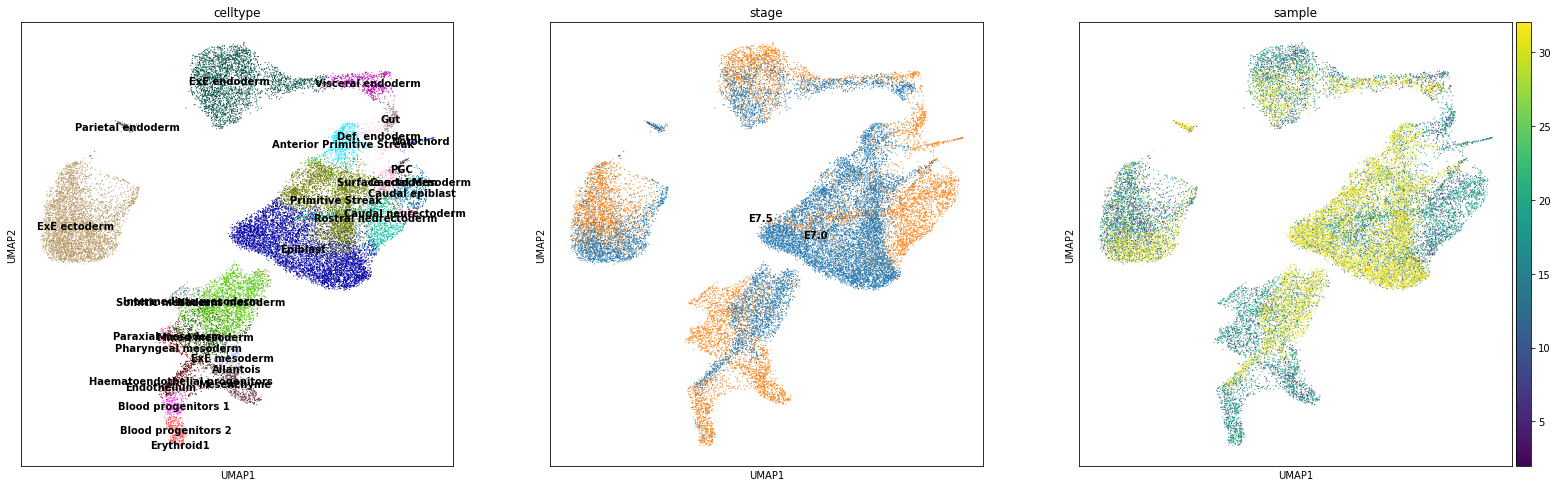

In [12]:
sc.pl.umap(adata, color=["celltype","stage", "sample"], legend_loc="on data")

This is probably what your anndata looks like when you start thinking about differential abundance analysis. In the next section we will see how to use `r2py` and `anndata2ri` functionality to integrate _Milo_ differential abudance analysis in your python workflow.

## Differential abundance (DA) analysis with Milo

#### Make Milo object

To start with, we have to convert our anndata object back into a SingleCellExperiment. The `anndata2ri` converter doesn't seem to like converting anndata objects storing the KNN graph in the `adata.obsp` slot, probably because there is no dedicated slot in the `SingleCellExperiment` object. Because of this, we will first make a copy of our `anndata` without KNN graph for conversion.

In [13]:
adata_no_knn = adata.copy()
adata_no_knn.obsp = None
adata_no_knn.uns.pop("neighbors")
adata_no_knn

AnnData object with n_obs × n_vars = 25743 × 29452
    obs: 'cell', 'barcode', 'sample', 'pool', 'stage', 'sequencing.batch', 'theiler', 'doub.density', 'doublet', 'cluster', 'cluster.sub', 'cluster.stage', 'cluster.theiler', 'stripped', 'celltype', 'colour'
    var: 'ENSEMBL', 'SYMBOL'
    uns: 'umap', 'celltype_colors', 'stage_colors'
    obsm: 'pca.corrected', 'X_umap', 'X_pca'

This can be converted to a `SingleCellExperiment` using R magic again

In [14]:
%%R -i adata_no_knn
adata_no_knn

class: SingleCellExperiment 
dim: 29452 25743 
metadata(3): umap celltype_colors stage_colors
assays(1): X
rownames(29452): ENSMUSG00000051951 ENSMUSG00000089699 ...
  ENSMUSG00000096730 ENSMUSG00000095742
rowData names(2): ENSEMBL SYMBOL
colnames(25743): cell_361 cell_362 ... cell_114575 cell_114576
colData names(16): cell barcode ... celltype colour
reducedDimNames(3): pca.corrected UMAP PCA
spikeNames(0):
altExpNames(0):


And we can make a Milo class object for DA analysis

In [15]:
%%R 
milo <- Milo(adata_no_knn)
milo

class: Milo 
dim: 29452 25743 
metadata(3): umap celltype_colors stage_colors
assays(1): X
rownames(29452): ENSMUSG00000051951 ENSMUSG00000089699 ...
  ENSMUSG00000096730 ENSMUSG00000095742
rowData names(2): ENSEMBL SYMBOL
colnames(25743): cell_361 cell_362 ... cell_114575 cell_114576
colData names(16): cell barcode ... celltype colour
reducedDimNames(3): pca.corrected UMAP PCA
spikeNames(0):
altExpNames(0):
nhoods dimensions(1): 0
nhoodCounts dimensions(2): 1 1
nhoodDistances dimension(1): 0
graph names(0):
nhoodIndex names(1): 0
nhoodExpression dimension(2): 1 1
nhoodReducedDim names(0):
nhoodGraph names(0):


#### Add KNN graph

Milo looks for neighbourhoods in a KNN graph to perform DA analysis. This need to be stored in the `graph` slot of the `Milo` object. Here we have two options: 

1. we can add the KNN graph precomputed with `sc.pp.neighbors`, using the function `buildFromAdjacency`. To move an object from python to R chunks, we need to add `-i <py-object>` to the magic line. 

In [16]:
## Save the binary connectivity matrix
knn_adjacency = adata.obsp["connectivities"]

In [17]:
%%R -i knn_adjacency

milo_graph <- buildFromAdjacency(knn_adjacency, k=20, is.binary=TRUE)
graph(milo) <- graph(milo_graph)


Error in graph(milo_graph) : 'edges' must be numeric or character


2. we can recompute the KNN graph using the dedicated function in `miloR`. 

In [18]:
%%R 
milo <- buildGraph(milo, k=20, d=30)

#### Run Milo analysis

Now we are all set to run the different steps of the Milo analysis in our R chunks. Let's start by defining our design matrix. Here we are going to test for DA between cells in stage E6.5 and stage E7.25, while controlling for the sequencing batch

In [19]:
design_df = adata.obs[["sample","sequencing.batch", "stage"]]
design_df.drop_duplicates(inplace=True)
design_df.index = design_df['sample']
design_df

/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,sample,sequencing.batch,stage
sample,,,
2,2,1,E7.5
3,3,1,E7.5
4,4,1,E7.5
6,6,1,E7.5
10,10,1,E7.0
14,14,2,E7.0
15,15,2,E7.0
19,19,2,E7.5
20,20,2,E7.5


Then we just copy the steps from the package vignettes. Again, we need to give the design dataframe in input to the R chunk, and ask for the dataframe storing differential abundance results as output. 

In [20]:
%%R -i design_df -o DA_results
## Define neighbourhoods
milo <- makeNhoods(milo, prop = 0.1, k = 20, d=30, refined = TRUE)

## Count cells in neighbourhoods
milo <- countCells(milo, meta.data = data.frame(colData(milo)), sample="sample")

## Calculate distances between cells in neighbourhoods
## for spatial FDR correction
milo <- calcNhoodDistance(milo, d=30)

## Test for differential abundance
DA_results <- testNhoods(milo, design = ~ sequencing.batch + stage, design.df = design_df)

Now back to our beloved python

In [21]:
DA_results

,logFC,logCPM,F,PValue,FDR,Nhood,SpatialFDR
1,-3.805489,20.287587,8.797667,0.003021,0.007603,1.0,0.007788
2,2.877743,19.096255,6.006954,0.014260,0.026051,2.0,0.026135
3,4.434371,18.507093,11.134352,0.000849,0.002683,3.0,0.002799
4,-1.807354,18.781740,2.265045,0.132342,0.174175,4.0,0.173549
5,6.052190,18.923708,20.379329,0.000006,0.000064,5.0,0.000071
...,...,...,...,...,...,...,...
1778,6.549766,18.327550,16.642471,0.000045,0.000274,1778.0,0.000304
1779,6.235372,18.980084,19.374980,0.000011,0.000095,1779.0,0.000108
1780,-3.031845,18.639764,7.415041,0.006475,0.013753,1780.0,0.013913
1781,-2.625563,19.216428,5.393330,0.020226,0.034557,1781.0,0.034607


In the above dataframe, each row represents a neighbourhood (__NOT__ a cell) and the log-Fold Change and adjusted p-value for differential abundance between stages are reported. We can start exploring the test results with a volcano plot.

Text(0, 0.5, '- log10(Spatial FDR)')

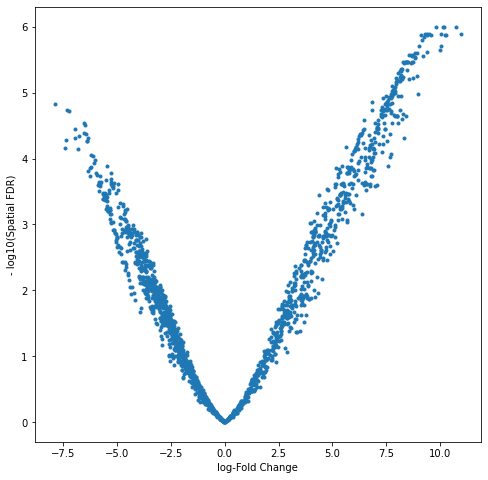

In [22]:
plt.plot(DA_results.logFC, -np.log10(DA_results.SpatialFDR), '.');
plt.xlabel("log-Fold Change");
plt.ylabel("- log10(Spatial FDR)")

#### Visualizing results from Milo analysis

To visualize DA results and relate them to the single-cell embedding, we build an abstracted graph of connecting neighbourhoods that have cells in common. This is implemented in the `buildNhoodGraph` function (shouldn't be too difficult to do a python implementation of this).

In [23]:
%%R
milo <- buildNhoodGraph(milo)

[1] "Calculating nhood adjacency...."


To visualize the graph, you have again multiple options. The first one is to just use the functionalities implemented in the `miloR` package in another R chunk.

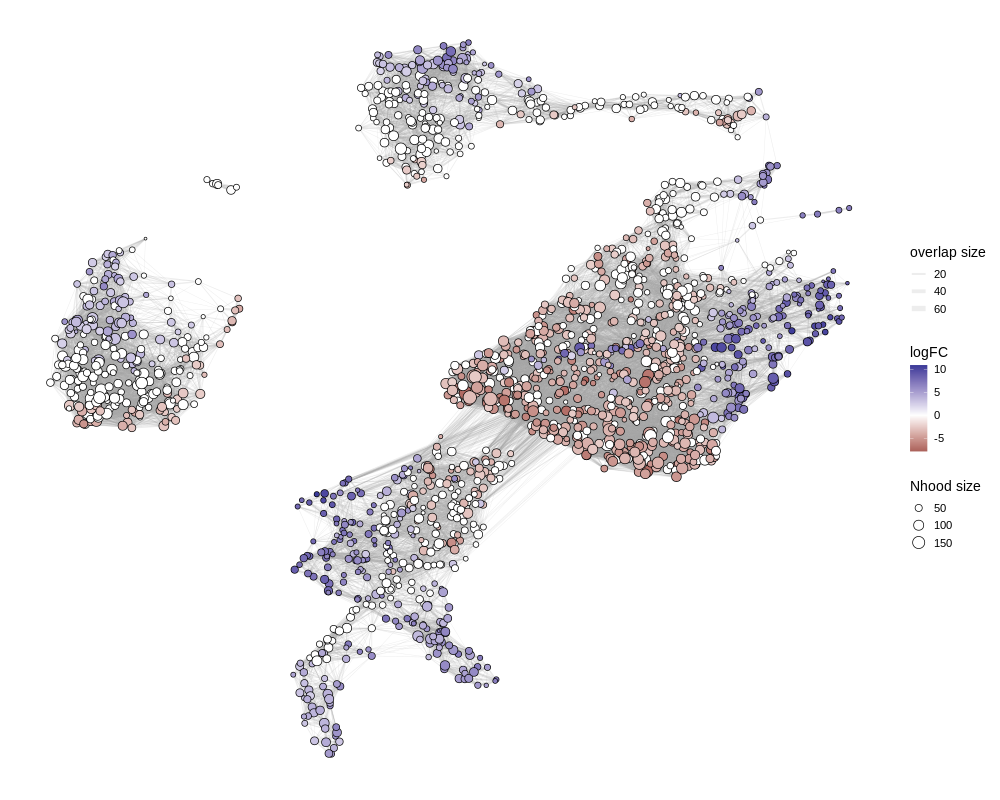

In [24]:
%%R -w 1000 -h 800
plotNhoodGraphDA(milo, DA_results, alpha=0.05)

Otherwise, If you can't take any more R, then you can make an `anndata` object for the neighbourhoods, storing the abstracted graph in the `obsp` slot.

In [25]:
%%R -o nhood_graph
## Save the adjacency matrix of the nhood graph
nhood_graph = as_adjacency_matrix(nhoodGraph(milo), attr="weight")

In [26]:
%%R -o nh_umap_df
## Save the positions in UMAP of nhood indices
nh_umap_df = reducedDim(milo, "UMAP")[unlist(nhoodIndex(milo)),]

In [27]:
nhood_adata = anndata.AnnData(obs = DA_results)

In [28]:
## Add graph
nhood_graph_conn = nhood_graph.copy()
nhood_graph_conn[nhood_graph_conn > 1] = 1 

nhood_adata.uns["neighbors"] = {}
nhood_adata.obsp['distances'] = nhood_graph
nhood_adata.uns['neighbors']["distances"] = nhood_graph
nhood_adata.obsp['connectivities'] = nhood_graph_conn
nhood_adata.uns['neighbors']["connectivities"] = nhood_graph_conn

/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning: This location for 'distances' is deprecated. It has been moved to .obsp[distances], and will not be accesible here in a future version of anndata.
  import sys
/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/ipykernel_launcher.py:9: FutureWarning: This location for 'connectivities' is deprecated. It has been moved to .obsp[connectivities], and will not be accesible here in a future version of anndata.
  if __name__ == '__main__':


In [29]:
## Add umap positions
nhood_adata.obsm["X_umap"] = nh_umap_df

Then you can use scanpy functions for visualization (I'm looking into how to fully incorporate the adjacency matrix in the anndata object to add edges in the visualization).

/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])


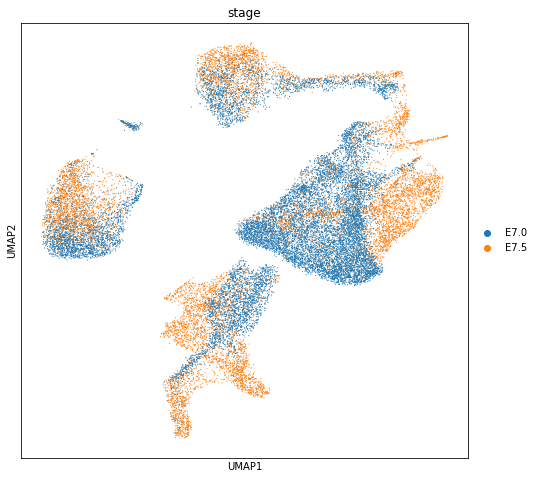

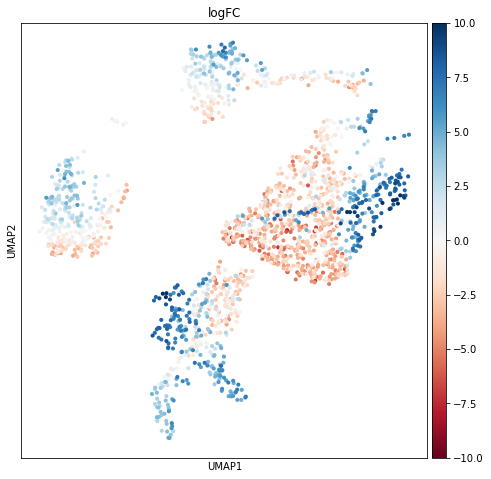

In [30]:
sc.pl.umap(adata, color="stage", vmax=10, vmin=-10)
sc.pl.umap(nhood_adata, color="logFC", cmap='RdBu', vmax=10, vmin=-10)

We can color only significant nhoods

In [31]:
nhood_adata.obs["logFC_signif"] = nhood_adata.obs["logFC"]
nhood_adata.obs["logFC_signif"][nhood_adata.obs["SpatialFDR"] > 0.1] = 0

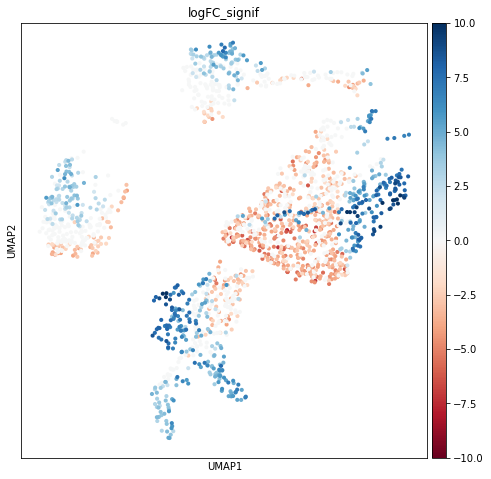

In [32]:
sc.pl.umap(nhood_adata, color="logFC_signif", 
           cmap='RdBu', vmax=10, vmin=-10, 
           add_outline = False
          )

## More questions? Ideas?
If you have questions or any ideas on how to enhance interoperability with anndata/scanpy please get in touch (ed6@sanger.ac.uk)

---

## Session info

In [33]:
sc.logging.print_versions()

-----
anndata     0.7.4
scanpy      1.6.0
sinfo       0.3.1
-----
PIL                 7.2.0
anndata             0.7.4
anndata2ri          1.0.4
atomicwrites        1.3.0
attr                20.2.0
backcall            0.2.0
cffi                1.14.3
colorama            0.4.3
cycler              0.10.0
cython_runtime      NA
dateutil            2.8.1
decorator           4.4.2
future_fstrings     NA
get_version         2.1
google              NA
h5py                2.10.0
igraph              0.8.2
importlib_metadata  0.23
ipykernel           5.3.4
ipython_genutils    0.2.0
jedi                0.17.2
jinja2              2.11.2
joblib              0.14.0
kiwisolver          1.1.0
legacy_api_wrap     1.2
leidenalg           0.8.1
llvmlite            0.34.0
louvain             0.6.1+2.g8073db7
markupsafe          1.1.1
matplotlib          3.3.2
more_itertools      NA
mpl_toolkits        NA
natsort             6.0.0
numba               0.51.2
numexpr             2.7.0
numpy               1.19